In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.attn_kq import *
from gptopt.optim.nesterov import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Smooth relaxation of primal problem
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{1}{2\mu }\|(|\mathcal{A}(Z)| - \beta)_+\|_F^2
\end{array}  
$$

## Nesterov for primal problem
$$
\begin{align}
\nabla f(U^k) &= G + \frac{1}{\mu} \mathcal{A}^*\left (\mathcal{A}(U^k) 
- \Pi_{[-\beta, \beta]}(\mathcal{A}(U^k))\right ) \\
Z^{k+1} &= U^k - \frac{\mu}{{\|\mathcal{A}\|_{\operatorname{op}}^2}} \nabla f(U^k) \\
U^{k+1} &= Z^{k+1} + \frac{k-1}{k+2} (Z^{k+1} - Z^k)
\end{align}
$$

In [4]:
for (m, n) in [(20, 40), (40, 20), (40, 40)]:
    for _ in range(2):
        # NumPy data for CVXPY reference
        A2_np = np.random.randn(m, n)
        A1_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np
        beta = 1

        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA2 = torch.linalg.norm(A2, ord="fro").item()
        nA1 = torch.linalg.norm(A1, ord="fro").item()
        lamb_max = (nA2 * nA2 + nA1 * nA1) ** 0.5
        mu_reg = max(1e-2 * lamb_max**2, 1e-6)

        Z0_1, Z0_2, obj0 = cvxpy_lmax_smooth(A2_np, A1_np, G1_np, G2_np, beta, mu_moreau=mu_reg)

        A_linop = attn_linop_from_matrices(A1, A2)
        Grad = torch.cat([G1, G2], dim=0)
 
        Z_t, residuals = nesterov_lmax_moreau(
                A_linop=A_linop, Grad=Grad,
                beta=beta, mu=mu_reg, 
                lamb_max=lamb_max, max_iter=10000,
                eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                pd_residuals=pd_residuals_max_ball_linop
            )
        assert residuals["r_rel"][-1] < 1e-4 
        assert np.allclose(residuals['primal_vals'][-1], obj0, rtol=1e-4)
        
        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            torch.trace(Z_t[:m, :].T @ G1 + Z_t[m:, :].T @ G2).item(),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.allclose(torch.max(torch.abs(A_linop.matvec(Z_t))).item(),
               np.max( np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)), rtol=1e-3)


print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PASSED


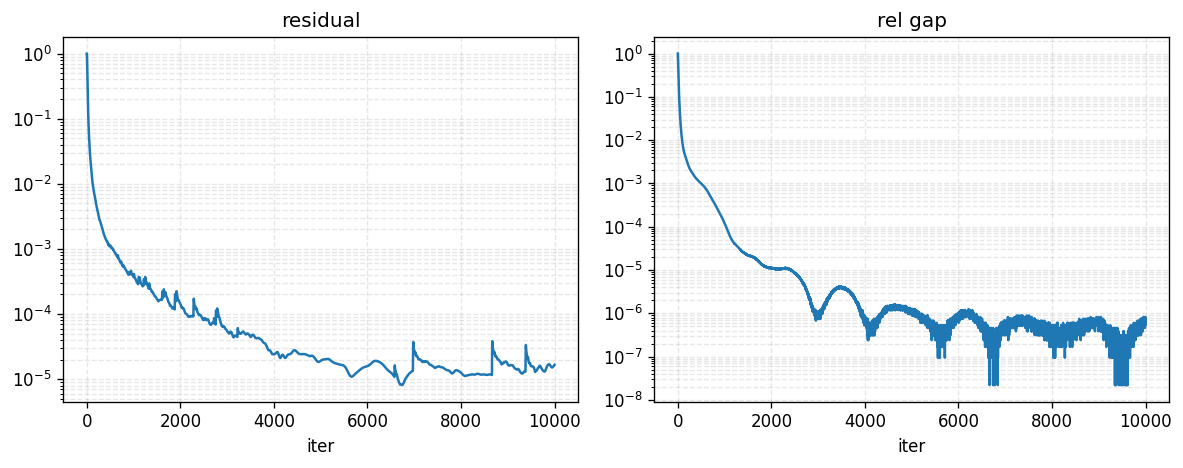

In [5]:
def plot_residuals_and_gap(logging, obj0):
    r = np.array(logging["r_rel"])
    loss = np.array(logging["primal_vals"])
    gap = np.abs(loss - obj0) / max(1.0, abs(obj0))
    it = np.arange(1, len(r) + 1)
   
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    ax[0].plot(it, r);    ax[0].set_yscale("log"); ax[0].set_title("residual"); ax[0].set_xlabel("iter")
    ax[1].plot(it, gap);  ax[1].set_yscale("log"); ax[1].set_title("rel gap");  ax[1].set_xlabel("iter")
    for a in ax: a.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()

    
plot_residuals_and_gap(residuals, obj0)

In [6]:
mu_reg

31.67533783948122

#  $m=n=50$

In [10]:
m = n = 50
std2 = 1  
A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, rank_ratio=1,
                                                                 G_in_range=True)

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)


mu_max = A_linop.matvec(Grad).abs().max().item() / beta
lamb_max = (A1.pow(2).sum().item() + A2.pow(2).sum().item()) ** 0.5

# mu_reg = max(0.1 * mu_max, 1e-6)
mu_reg = max(1e-2 * lamb_max**2, 1e-6)
print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=7.0951e+01, mu_max=1.2609e+01


In [11]:
Z_star_1, Z_star_2, f_star = cvxpy_lmax_smooth(A2_np, A1_np, G1_np, G2_np, beta, mu_moreau=mu_reg)

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
Z_t, residuals = nesterov_lmax_moreau(
                A_linop=A_linop, Grad=Grad,
                beta=beta, mu=mu_reg, 
                lamb_max=lamb_max, max_iter=10000,
                eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                pd_residuals=pd_residuals_max_ball_linop)

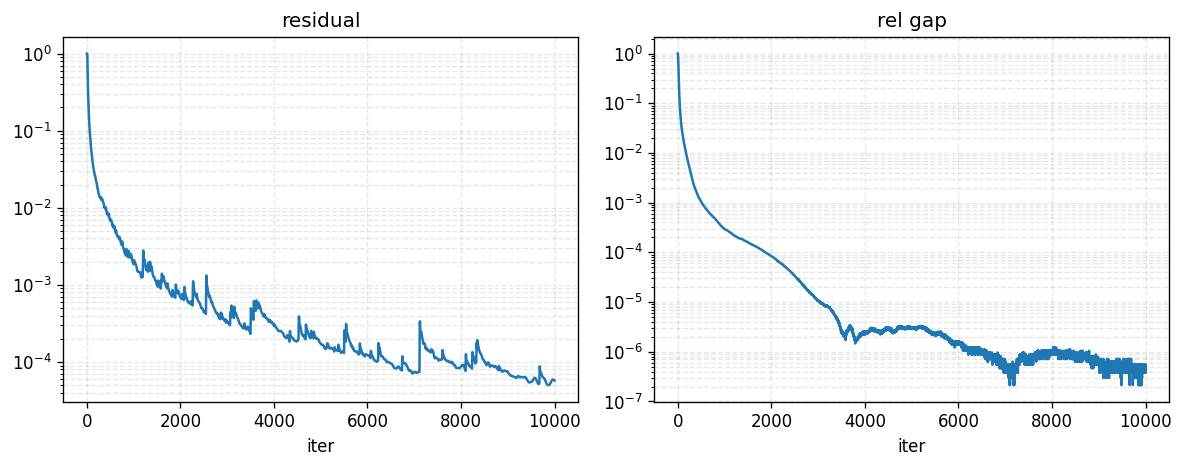

In [13]:
plot_residuals_and_gap(residuals, f_star)

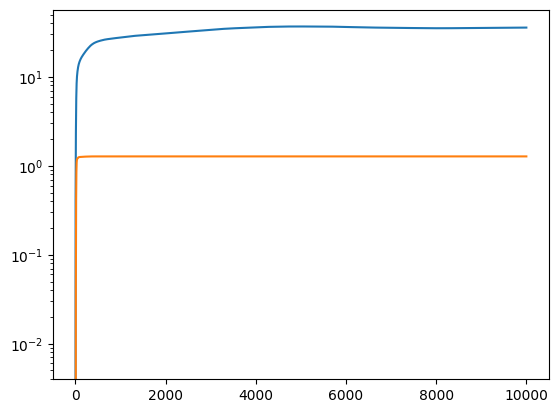

In [14]:
plt.plot(residuals["z_norm"], label="z_norm")
plt.plot(residuals["y_norm"], label="y_norm")
plt.yscale("log")

In [15]:
mu_reg, max(1e-2 * lamb_max**2, 1e-6)

(50.34069091796874, 50.34069091796874)